# Exercise 4+5+6

In [235]:
def Modeldefs4(Xp, X, Z, params):
    # unpack input vectors
    (kp, ellp)=Xp
    (k, ell)=X
    z= Z
    
    # find definintion values
    Y = k**alpha*(np.exp(z)*ell)**(1-alpha)
    w = (1-alpha)*Y/ell
    r = alpha*Y/k
    T = tau*(w*ell+(r-delta)*k)
    c = (1-tau)*(w*ell + (r - delta)*k) + k + T - kp
    u = (c**(1-gamma)-1)/(1-gamma) + a*((1-ell)**(1-xi)-1)/(1-xi)
    return Y, w, r, c, u

In [304]:
def Modeldyn4(theta0, params):    
    Xpp=theta0[:2]
    Xp=theta0[2:4]
    X=theta0[4:6]
    Zp=theta0[6]
    Z=theta0[7]
    # find definitions for now and next period
    Y, w, r, c, u = Modeldefs4(Xp, X, Z, params)
    Yp, wp, rp, cp, up = Modeldefs4(Xpp, Xp, Zp, params)
    
    # Evaluate Euler equations
    ell=Xp[1]
    E1 = (c**(-gamma) * w * (1-tau)* (1-ell)**(xi) )/(a) - 1
    E2 = (c**(-gamma)) / (beta * cp**(-gamma) * (1 + (1-tau)*(rp - delta))) - 1
    
    
    return np.array([E1, E2])

In [282]:
import numpy as np
import scipy as sp
import scipy.stats as sts
import matplotlib.pyplot as plt
import scipy.optimize as opt
from LinApp_FindSS import LinApp_FindSS
from LinApp_Deriv import LinApp_Deriv
from LinApp_Solve import LinApp_Solve

In [291]:

# set parameter values
alpha = .4
beta = .98
gamma = 2.5
delta = .1
xi=1.5
rho = .9
a=0.5
tau=0.05
sigma = .02

# make parameter list to pass to functions
params = (alpha, beta, gamma, delta, tau, a, rho, xi, sigma)

# set LinApp parameters
Zbar = np.array([0.])
nx = 2
ny = 0
nz = 1
logX = 0
Sylv = 0

In [296]:
# take a guess for steady state values of k and ell
guessXY = np.array([3, .25])

# find the steady state values using LinApp_FindSS
XYbar = LinApp_FindSS(Modeldyn4, params, guessXY, Zbar, nx, ny)
(kbar, ellbar) = XYbar
print ('Xbar: ', XYbar)

# set up steady state input vector
theta0 = np.array([kbar, ellbar, kbar, ellbar, kbar, ellbar, 0., 0.])

# check SS solution
check = Modeldyn4(theta0, params)
print ('check: ', check)
if np.max(np.abs(check)) > 1.E-6:
    print ('Have NOT found steady state')

Xbar:  [ 4.22522903  0.57979145]
check:  [ -4.88498131e-15   0.00000000e+00]


In [300]:
Ybar, wbar, rbar, cbar, ubar = Modeldefs4(np.array([kbar, ellbar]), np.array([kbar, ellbar]), 0, params)
print ('Ybar: ', Ybar)
print ('wbar: ', wbar)
print ('rbar: ', rbar)
print ('cbar: ', cbar)
print ('ubar: ', ubar)
print('ibar: ', Ybar-cbar)
print('Tbar: ', tau*(wbar*ellbar+(rbar-delta)*kbar))

Ybar:  1.28322610883
wbar:  1.32795276835
rbar:  0.121482277121
cbar:  0.860703206154
ubar:  -0.710872638118
ibar:  0.422522902678
Tbar:  0.0430351603077


In [305]:
# find the derivatives matrices
[AA, BB, CC, DD, FF, GG, HH, JJ, KK, LL, MM, WW, TT] = \
    LinApp_Deriv(Modeldyn4, params, theta0, nx, ny, nz, logX)
print('FF: ', FF)
print('GG: ', GG)
print('HH: ', HH)
print('LL: ', LL)
print('MM: ', MM)

# set value for NN    
NN = rho
    
# find the policy and jump function coefficients
PP, QQ, UU, RR, SS, VV = \
    LinApp_Solve(AA,BB,CC,DD,FF,GG,HH,JJ,KK,LL,MM,WW,TT,NN,Zbar,Sylv)
print ('PP:',PP)
print ('QQ', QQ)
print ('RR:',RR)
print ('SS', SS)
print ('NN', NN)

FF:  [[ 0.         0.       ]
 [-2.9046017  0.       ]]
GG:  [[ 2.90460171 -3.56965609]
 [ 5.88766154  3.74013179]]
HH:  [[-2.87232974 -4.54707712]
 [-2.96699916 -3.85717388]]
LL:  [[ 0.        ]
 [ 2.16849645]]
MM:  [[-1.63635645]
 [-2.23635645]]
PP: [[ 0.948518    1.24234892]
 [-0.03284987 -0.26292402]]
QQ [[ 0.55158563]
 [-0.00958633]]
RR: []
SS []
NN 0.9


# Exercise 7

In [406]:
sigma=np.sqrt(0.0004)
z=0
kbar, ellbar=Xbar
X0=np.array([4,0.5])
Zsim=0.1*np.ones((250,10000))
Xtildesim=np.ones((250,20000))

In [407]:
Xtilde0=np.log(X0)-np.log(Xbar)
Xtildesim[0,::2]=Xtilde0[0]
Xtildesim[0,1::2]=Xtilde0[1]
for t in range(1,250,1):
    Zsim[t,:]=rho*Zsim[t-1,:]+sigma*np.random.randn(10000)

In [408]:
for t in range(1,250,1):
    for s in range(10000):
        Xtildesim[t,(2*s):(2*s)+2]=np.dot(PP, Xtildesim[t-1,(2*s):(2*s)+2])+np.dot(QQ,np.array([Zsim[t,s]]))

In [409]:
Xsim[:,::2]=kbar*np.exp(Xtildesim[:,::2])
Xsim[:,1::2]=ellbar*np.exp(Xtildesim[:,1::2])
ksim=Xsim[:,::2]
ellsim=Xsim[:,1::2]
Ysim=ksim**(alpha)*(ellsim*np.exp(Zsim))**(1-alpha)
wsim = (1-alpha)*Ysim/ellsim
rsim = alpha*Ysim/ksim
Tsim = tau*(wsim*ellsim+(rsim-delta)*ksim)
csim = (1-tau)*(wsim[:-1,:]*ellsim[:-1,:] + (rsim[:-1,:] - delta)*ksim[:-1,:]) + ksim[:-1,:] + Tsim[:-1,:] - ksim[1:,:]
isim = Ysim[:-1,:]-csim

In [410]:
cmean=csim.mean(axis=1)
c95=np.percentile(csim,95,axis=1)
c05=np.percentile(csim,5,axis=1)
Ymean=Ysim.mean(axis=1)
Y95=np.percentile(Ysim,95,axis=1)
Y05=np.percentile(Ysim,5,axis=1)
imean=isim.mean(axis=1)
i95=np.percentile(isim,95,axis=1)
i05=np.percentile(isim,5,axis=1)
ellmean=ellsim.mean(axis=1)
ell95=np.percentile(ellsim,95,axis=1)
ell05=np.percentile(ellsim,5,axis=1)

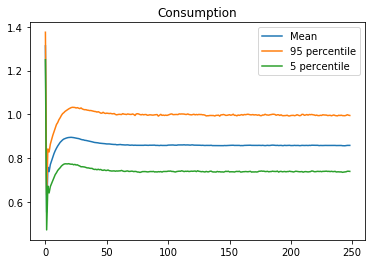

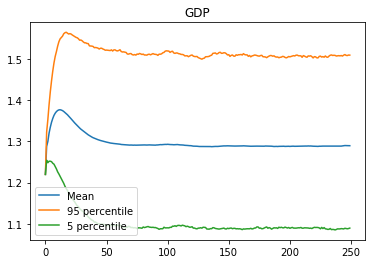

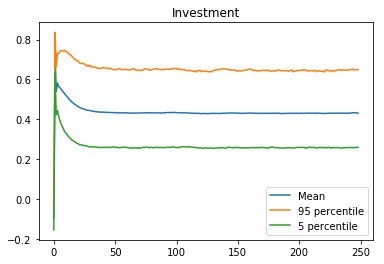

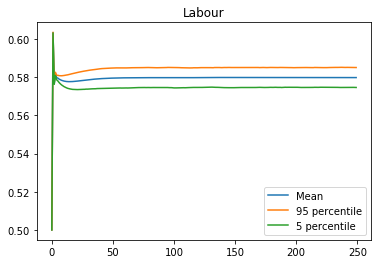

In [411]:
plt.plot(cmean, label='Mean')
plt.plot(c95, label='95 percentile')
plt.plot(c05, label='5 percentile')
plt.legend()
plt.title('Consumption')
plt.show()
plt.plot(Ymean, label='Mean')
plt.plot(Y95, label='95 percentile')
plt.plot(Y05, label='5 percentile')
plt.legend()
plt.title('GDP')
plt.show()
plt.plot(imean, label='Mean')
plt.plot(i95, label='95 percentile')
plt.plot(i05, label='5 percentile')
plt.legend()
plt.title('Investment')
plt.show()
plt.plot(ellmean, label='Mean')
plt.plot(ell95, label='95 percentile')
plt.plot(ell05, label='5 percentile')
plt.legend()
plt.title('Labour')
plt.show()

# Exercise 8

Mean

In [377]:
print('Consumption mean=',csim.mean(axis=0).mean(),'\nStd=',csim.mean(axis=0).std())
print('Investment mean=', isim.mean(axis=0).mean(), '\nStd=',isim.mean(axis=0).std())
print('GDP mean=',Ysim.mean(axis=0).mean(), '\nStd=',Ysim.mean(axis=0).std())
print('Labour mean=',ellsim.mean(axis=0).mean(),'\nStd=',ellsim.mean(axis=0).std())

Consumption mean= 0.860869561621 
Std= 0.0138801926134
Investment mean= 0.438511211015 
Std= 0.03508958074
GDP mean= 1.29934167564 
Std= 0.048291388015
Labour mean= 0.579321801744 
Std= 0.00122239372854


Volativity

In [376]:
print('Consumption avg. volativity=',csim.std(axis=0).mean(),'\nStd=',csim.std(axis=0).std())
print('Investment avg. volativity=', isim.std(axis=0).mean(), '\nStd=',isim.std(axis=0).std())
print('GDP avg. volativity=',Ysim.std(axis=0).mean(), '\nStd=',Ysim.std(axis=0).std())
print('Labour avg. volativity=',ellsim.mean(axis=0).mean(),'\nStd=',ellsim.std(axis=0).std())

Consumption avg. volativity= 0.0858847995752 
Std= 0.0090820920788
Investment avg. volativity= 0.122622543353 
Std= 0.019467983938
GDP avg. volativity= 0.115446425666 
Std= 0.0252604322239
Labour avg. volativity= 0.579321801744 
Std= 0.000318030495568


Coefficient of variation

In [381]:
print('Consumption avg. Coeff=',((csim.mean(axis=0))/(csim.std(axis=0))).mean(),'\nStd=',\
      ((csim.mean(axis=0))/(csim.std(axis=0))).std())
print('Investmnt avg. Coeff=',((isim.mean(axis=0))/(isim.std(axis=0))).mean(),'\nStd=',\
      ((isim.mean(axis=0))/(isim.std(axis=0))).std())
print('GDP avg. Coeff=',((Ysim.mean(axis=0))/(Ysim.std(axis=0))).mean(),'\nStd=',\
      ((Ysim.mean(axis=0))/(Ysim.std(axis=0))).std())
print('Labor avg. Coeff=',((ellsim.mean(axis=0))/(ellsim.std(axis=0))).mean(),'\nStd=',\
      ((ellsim.mean(axis=0))/(ellsim.std(axis=0))).std())

Consumption avg. Coeff= 10.1268994764 
Std= 0.997811750149
Investmnt avg. Coeff= 3.64087962285 
Std= 0.485182757506
GDP avg. Coeff= 11.7894544923 
Std= 2.59741361723
Labor avg. Coeff= 97.1113694948 
Std= 4.91535824009


Relative volativity

In [383]:
print('Consumption avg. relative volativity=',((csim.std(axis=0))/(Ysim.std(axis=0))).mean(),'\nStd=',\
      ((csim.std(axis=0))/(Ysim.std(axis=0))).std())
print('Investment avg. relative volativity=',((isim.std(axis=0))/(Ysim.std(axis=0))).mean(),'\nStd=',\
      ((isim.std(axis=0))/(Ysim.std(axis=0))).std())
print('Labor avg. relative volativity=',((ellsim.std(axis=0))/(Ysim.std(axis=0))).mean(),'\nStd=',\
      ((ellsim.std(axis=0))/(Ysim.std(axis=0))).std())

Consumption avg. relative volativity= 0.766583100576 
Std= 0.119017941451
Investment avg. relative volativity= 1.07998688288 
Std= 0.110542176603
Labor avg. relative volativity= 0.0537958169253 
Std= 0.0096301608932


Cyclicality

In [420]:
ccyc=np.ones(10000)
icyc=np.ones(10000)
ellcyc=np.ones(10000)
for i in range(10000):
    ccyc[i]=np.corrcoef(csim[:,i],Ysim[:-1,i])[0,1]
    icyc[i]=np.corrcoef(isim[:,i],Ysim[:-1,i])[0,1]
    ellcyc[i]=np.corrcoef(ellsim[:,i],Ysim[:,i])[0,1]

In [421]:
print('Consumption avg. cyclicality=',ccyc.mean(),'\nStd=',ccyc.std())
print('Investment avg. cyclicality=',icyc.mean(),'\nStd=',icyc.std())
print('Labor avg. cyclicality=',ellcyc.mean(),'\nStd=',ellcyc.std())

Consumption avg. cyclicality= 0.285914805475 
Std= 0.0875673750916
Investment avg. cyclicality= 0.732777360922 
Std= 0.050334883921
Labor avg. cyclicality= -0.409429187657 
Std= 0.0930733115943


# Exercise 9

In [414]:
Znewsim=Zsim
Xtildesim1=np.ones((250,20000))
for t in range(41):
    Znewsim[t,:]=Zsim[t,:]+0.1

In [415]:
for t in range(1,250,1):
    for s in range(10000):
        Xtildesim1[t,(2*s):(2*s)+2]=np.dot(PP, Xtildesim1[t-1,(2*s):(2*s)+2])+np.dot(QQ,np.array([Znewsim[t,s]]))

In [417]:
Xsim1=np.ones((250,20000))
Xsim1[:,::2]=kbar*np.exp(Xtildesim1[:,::2])
Xsim1[:,1::2]=ellbar*np.exp(Xtildesim1[:,1::2])
ksim1=Xsim1[:,::2]
ellsim1=Xsim1[:,1::2]
Ysim1=ksim1**(alpha)*(ellsim1*np.exp(Znewsim))**(1-alpha)
wsim1 = (1-alpha)*Ysim1/ellsim1
rsim1 = alpha*Ysim1/ksim1
Tsim1 = tau*(wsim1*ellsim1+(rsim1-delta)*ksim1)
csim1 = (1-tau)*(wsim1[:-1,:]*ellsim1[:-1,:] + (rsim1[:-1,:] - delta)*ksim1[:-1,:]) + ksim1[:-1,:] + Tsim1[:-1,:] - ksim1[1:,:]
isim1 = Ysim1[:-1,:]-csim1

In [418]:
cmean1=csim1.mean(axis=1)
c951=np.percentile(csim1,95,axis=1)
c051=np.percentile(csim1,5,axis=1)
Ymean1=Ysim1.mean(axis=1)
Y951=np.percentile(Ysim1,95,axis=1)
Y051=np.percentile(Ysim1,5,axis=1)
imean1=isim1.mean(axis=1)
i951=np.percentile(isim1,95,axis=1)
i051=np.percentile(isim1,5,axis=1)
ellmean1=ellsim1.mean(axis=1)
ell951=np.percentile(ellsim1,95,axis=1)
ell051=np.percentile(ellsim1,5,axis=1)

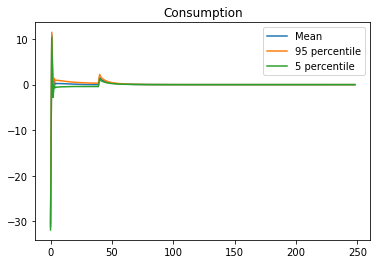

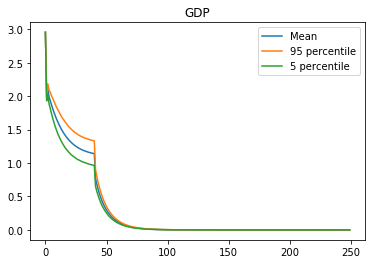

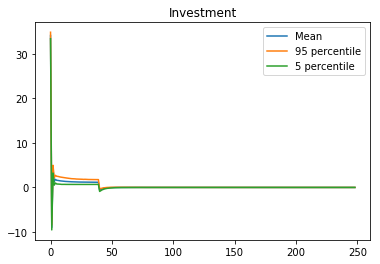

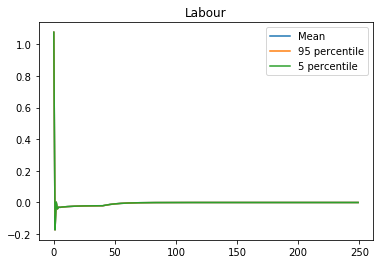

In [419]:
plt.plot(cmean1-cmean, label='Mean')
plt.plot(c951-c95, label='95 percentile')
plt.plot(c051-c05, label='5 percentile')
plt.legend()
plt.title('Consumption')
plt.show()
plt.plot(Ymean1-Ymean, label='Mean')
plt.plot(Y951-Y95, label='95 percentile')
plt.plot(Y051-Y05, label='5 percentile')
plt.legend()
plt.title('GDP')
plt.show()
plt.plot(imean1-imean, label='Mean')
plt.plot(i951-i95, label='95 percentile')
plt.plot(i051-i05, label='5 percentile')
plt.legend()
plt.title('Investment')
plt.show()
plt.plot(ellmean1-ellmean, label='Mean')
plt.plot(ell951-ell95, label='95 percentile')
plt.plot(ell051-ell05, label='5 percentile')
plt.legend()
plt.title('Labour')
plt.show()